In [1]:
import os
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import shutil
import random
import tensorflow as tf
from tensorflow import keras
import tensorflow_hub as hub
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dense, Flatten, Dropout, BatchNormalization, GlobalAveragePooling2D, Activation, GlobalMaxPool2D, BatchNormalization
from tensorflow.keras.optimizers import Adam, Nadam
from tensorflow.keras import Input, Model
from tensorflow.keras.utils import plot_model
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import splitfolders

In [2]:
# splits dataset it into three subfolders: train, val (validation), and test.

splitfolders.ratio(r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Plant_Disease\Dataset", output="output",
    seed=1337, ratio=(.75, .2, .05), group_prefix=None, move=False)

Copying files: 150 files [00:00, 193.35 files/s]


In [3]:
data_dir = pathlib.Path('output/')
train_dir = 'output/train'
val_dir = 'output/val'
test_dir = 'output/test'

In [4]:
class_name = np.array(sorted([item.name for item in data_dir.glob("*")]))
print(class_name)

['test' 'train' 'val']


In [5]:
for dirpath, dirnames, filenames in os.walk('output'):
  print(f"{len(dirnames)} folder and {len(filenames)} images in {dirpath}")

3 folder and 0 images in output
3 folder and 0 images in output\test
0 folder and 3 images in output\test\Healthy
0 folder and 3 images in output\test\Powdery
0 folder and 3 images in output\test\Rust
3 folder and 0 images in output\train
0 folder and 37 images in output\train\Healthy
0 folder and 37 images in output\train\Powdery
0 folder and 37 images in output\train\Rust
3 folder and 0 images in output\val
0 folder and 10 images in output\val\Healthy
0 folder and 10 images in output\val\Powdery
0 folder and 10 images in output\val\Rust


In [6]:
def view_random_image(target_dir, target_class):
    target_folder = target_dir + target_class
    random_image = random.sample(os.listdir(target_folder), 1)
    img = mpimg.imread(target_folder + "/" + random_image[0])
    plt.imshow(img)
    plt.title(target_class)
    plt.axis("off")
    
    print(f"Image Shape : {img.shape}")
    plt.show()

Image Shape : (2672, 4000, 3)


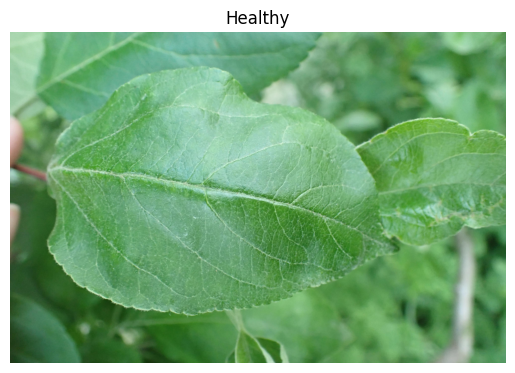

In [7]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Healthy')

Image Shape : (2672, 4000, 3)


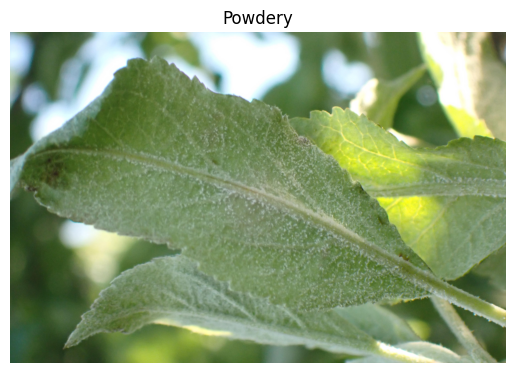

In [8]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Powdery')

Image Shape : (1728, 2592, 3)


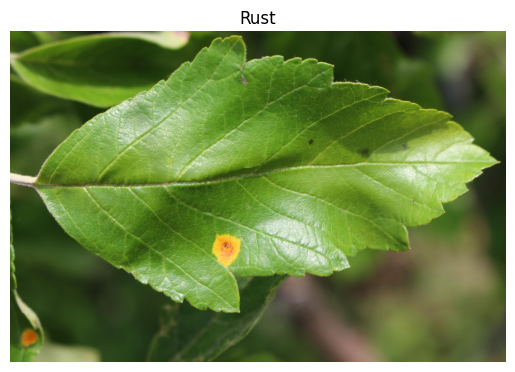

In [9]:
for i in range(1,2):
    img_n = view_random_image(target_dir='output/train/', target_class='Rust')

In [10]:
# Sets the global random seed.
tf.random.set_seed(46)

# preprocess data
train_datagen = ImageDataGenerator(rescale=1/255.0,
                                   rotation_range=0.2,
                                   zoom_range=0.2,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   vertical_flip=True,
                                   horizontal_flip=True)
valid_datagen = ImageDataGenerator(rescale=1/255.0)
test_datagen = ImageDataGenerator(rescale=1/255.0)

In [11]:
train_data = train_datagen.flow_from_directory(train_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=True,
                                               seed=46)

valid_data = valid_datagen.flow_from_directory(val_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

test_data = test_datagen.flow_from_directory(test_dir,
                                               batch_size=64,
                                               target_size=(224, 224),
                                               class_mode='categorical',
                                               shuffle=False,
                                               seed=46)

Found 111 images belonging to 3 classes.
Found 30 images belonging to 3 classes.
Found 9 images belonging to 3 classes.


In [12]:
train_data.class_indices

{'Healthy': 0, 'Powdery': 1, 'Rust': 2}

In [13]:
train_y=train_data.classes
val_y=valid_data.classes
test_y=test_data.classes

In [14]:
print("train_y.shape: ", train_y.shape)
print("val_y.shape: ", val_y.shape)
print("test_y.shape: ", test_y.shape)

train_y.shape:  (111,)
val_y.shape:  (30,)
test_y.shape:  (9,)


In [15]:
base_model = tf.keras.applications.DenseNet121(input_shape=(224, 224, 3),
                                                        include_top=False,
                                                        weights='imagenet')
base_model.trainable = False

In [16]:
global_average_layer = GlobalAveragePooling2D()
prediction_layer = Dense(3)
softmax = Activation('softmax')

inputs = Input(shape=(224, 224, 3))
x = base_model(inputs, training=False)
x = Dropout(0.25)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
outputs = softmax(outputs)

model = Model(inputs, outputs)

In [17]:
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ densenet121 (Functional)        │ (None, 7, 7, 1024)     │     7,037,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 7, 7, 1024)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1024)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 3)              │         3,075 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 3)              │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 7,040,579 (26.86 MB)

 Trainable params: 3,075 (12.01 KB)

 Non-trainable params: 7,037,504 (26.85 MB)

In [18]:
plot_model(model, show_shapes=True)

You must install graphviz (see instructions at https://graphviz.gitlab.io/download/) for `plot_model` to work.


In [19]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(learning_rate=0.001),
              metrics=['accuracy'])

# train model
history = model.fit(train_data, epochs=50, validation_data=valid_data)

Epoch 1/50


C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 42s 16s/step - accuracy: 0.3346 - loss: 1.2595 - val_accuracy: 0.3667 - val_loss: 1.1466
Epoch 2/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 10s/step - accuracy: 0.2653 - loss: 1.2151 - val_accuracy: 0.4667 - val_loss: 1.0825
Epoch 3/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 9s/step - accuracy: 0.4121 - loss: 1.0921 - val_accuracy: 0.4000 - val_loss: 1.0336
Epoch 4/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.4383 - loss: 1.1181 - val_accuracy: 0.4667 - val_loss: 0.9737
Epoch 5/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 19s 8s/step - accuracy: 0.4793 - loss: 1.0354 - val_accuracy: 0.6667 - val_loss: 0.9268
Epoch 6/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 23s 10s/step - accuracy: 0.4782 - loss: 1.0209 - val_accuracy: 0.6000 - val_loss: 0.8785
Epoch 7/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 24s 11s/step - accuracy: 0.5322 - loss: 0.9242 - val_accuracy: 0.6000 - val_loss: 0.8308
Epoch 8/50
2/2 ━━━━━━━━━━━━━━━━━━━━ 20s 9s/step - accuracy: 0.6223 - loss: 0.8711 - val_accuracy: 0.6667 - val_loss: 0.7817
Epoch 9/50
2/2 

In [20]:
model.save('my_model.keras')

In [21]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(loss))

  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title("Loss Curves")
  plt.xlabel("Epochs")
  plt.legend()

  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title("Accuracy Curves")
  plt.xlabel("Epochs")
  plt.legend()

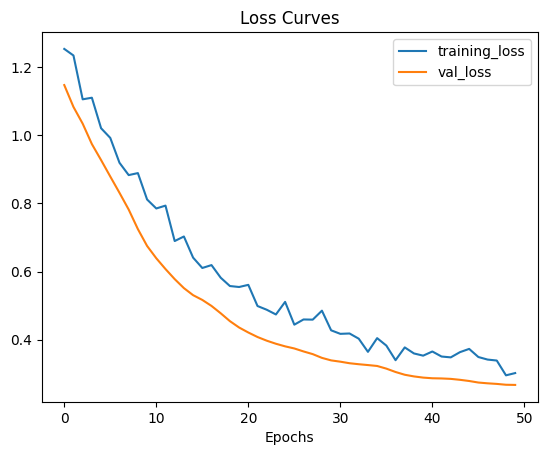

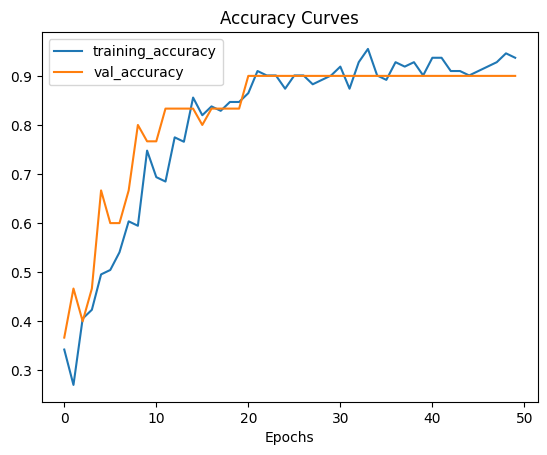

In [22]:
plot_loss_curves(history)

In [23]:
val_pred = model.predict(valid_data)
val_pred = val_pred.argmax(axis=1)
print(classification_report(val_pred, val_y))

1/1 ━━━━━━━━━━━━━━━━━━━━ 7s 7s/step
              precision    recall  f1-score   support

           0       1.00      0.83      0.91        12
           1       0.90      1.00      0.95         9
           2       0.80      0.89      0.84         9

    accuracy                           0.90        30
   macro avg       0.90      0.91      0.90        30
weighted avg       0.91      0.90      0.90        30



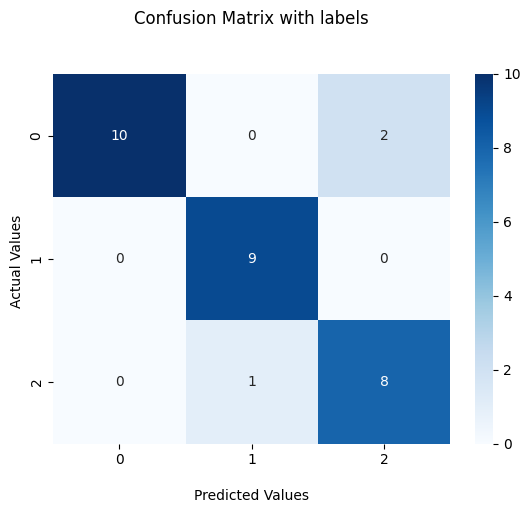

In [24]:
cfm_val = confusion_matrix(val_pred, val_y)
ax = sns.heatmap(cfm_val, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [25]:
test_pred = model.predict(test_data)
test_pred = test_pred.argmax(axis=1)
print(classification_report(test_pred, test_y))

C:\Users\ajayk\anaconda3\envs\py310\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
              precision    recall  f1-score   support

           0       1.00      1.00      1.00         3
           1       1.00      1.00      1.00         3
           2       1.00      1.00      1.00         3

    accuracy                           1.00         9
   macro avg       1.00      1.00      1.00         9
weighted avg       1.00      1.00      1.00         9



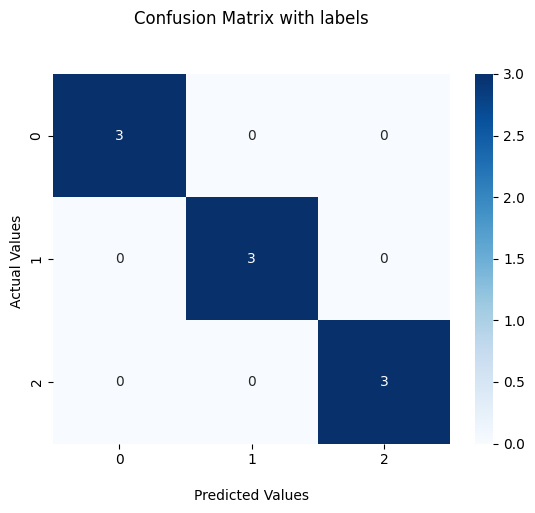

In [26]:
cfm_test = confusion_matrix(test_pred, test_y)
ax = sns.heatmap(cfm_test, annot=True, 
            cmap='Blues')

# Preparation for plotting confusion matrix
ax.set_title('Confusion Matrix with labels\n\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

# Display the visualization of the Confusion Matrix.
plt.show()

In [27]:
!pip install opencv-python

1/1 ━━━━━━━━━━━━━━━━━━━━ 4s 4s/step
Predicted Class: Powdery


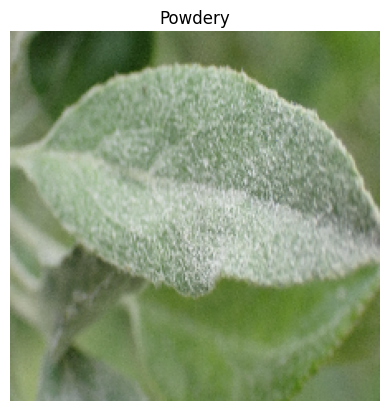

In [ ]:
import matplotlib.pyplot as plt
from keras.models import load_model
from tensorflow.keras.preprocessing import image
import numpy as np

# Load the trained model
model = load_model('my_model.keras')

# Load the image
image_path = r"C:\Users\ajayk\Desktop\InnoProjects\SRIT\Plant_Disease\output\val\Powdery\9f802f3f8a603cb5.jpg"
image = image.load_img(image_path, target_size=(224, 224))

# Preprocess the image
img = np.array(image)
img = img / 255.0
img = img.reshape(1, 224, 224, 3)

# Predict the label
label = model.predict(img)

# Determine the predicted class
class_names = ['Healthy', 'Powdery', 'Rust']
predicted_class_index = np.argmax(label)
predicted_class = class_names[predicted_class_index]

# Causes and fixes for different diseases
causes_and_fixes = {
    'Healthy': {
        'Cause': "No disease detected. The plant is healthy.",
        'Fix': "Maintain current care routines to keep the plant healthy."
    },
    'Powdery': {
        'Cause': "Caused by high humidity and poor air circulation, which encourage fungal spores to thrive.",
        'Fix': "Improve air circulation around the plant and avoid overhead watering. Apply fungicides if needed."
    },
    'Rust': {
        'Cause': "Triggered by wet conditions and prolonged leaf wetness, which promote fungal growth.",
        'Fix': "Remove affected leaves and avoid wetting leaves during watering. Use fungicides to prevent further spread."
    }
}

# Print the predicted class with cause and fix
print(f"Predicted Class: {predicted_class}")
print(f"Cause: {causes_and_fixes[predicted_class]['Cause']}")
print(f"Fix: {causes_and_fixes[predicted_class]['Fix']}")

# Display the image with the predicted label
plt.imshow(image)
plt.title(predicted_class)
plt.axis('off')
plt.show()
